In [2]:
%pip install imblearn
%pip install pandas
%pip install shap
%pip install matplot
%pip install seaborn
%pip install altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.1/389.1 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "

## expand a labeled dataset to SMOTE

magnify the number of minority/exceptional cases within the sequence dataset, ideally targets the binary binned dataset.

[reference 1](<ver5-ordinal-binning-grid-searches/step 2-0, ranged clustering, with time.ipynb>)

different oversampling tools: Naive random oversampling, SMOTE, ADASYN, SMOTENC, locate the most effective, while optimizing the accuracy of a binary classifier. ~98 accuracy

a set of ensemble methods are tested then compiled into a voting classifier. ~90 accuracy

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE,SMOTENC, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import pandas as pd 
import numpy as np

from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,RUSBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.inspection import DecisionBoundaryDisplay


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
m2_pipeline = pd.read_csv("../0 Data Processing/binary_binned_pipeline.csv")
corr_list = [
       'precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change','length', 'sum_change', 'surge_targets_met_pct','time', 'label']

m2_pipeline = m2_pipeline[corr_list]

In [3]:

keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
    
X_resampled, y_resampled = ADASYN(random_state=42 ).fit_resample(X, y) #create synthetic classes

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()  #standardize all numerics
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

In [4]:
m2_pipeline.columns #do this to identify the index of the categorical feature, for below setup

Index(['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'length', 'sum_change', 'surge_targets_met_pct', 'time', 'label'],
      dtype='object')

### take optimal classifier parameters and technique

In [5]:


classifiers = [  # Define the classifiers and their respective hyperparameters
    LogisticRegression(),
    BernoulliNB(),
    KNeighborsClassifier(),
]
params = {
    'LogisticRegression':{'C': [0.1, 1, 10], 'penalty':['l1','l2','elasticnet','None'], 'multi_class':['ovr','auto'],\
                            'random_state':[42]},
    'BernoulliNB':{'fit_prior':[True, False]},
    'KNeighborsClassifier':{'n_neighbors':[3,4,5,6,7,8], 'algorithm':['auto'], 'n_jobs':[1,2,3,4]}
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test_scaled, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
# return(comparative)


90 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/stefanbund/Library/Python/3.9/l

Best parameters for LogisticRegression: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
Best parameters for BernoulliNB: {'fit_prior': True}
Best parameters for KNeighborsClassifier: {'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}


## trigger the search mechanism, per SMOTE method

loop through each oversampled dataset, then run the classifier search on that set, outlining each set, before hand

for each set, run the classifier search

In [6]:
comparative

[{'classifier': 'LogisticRegression',
  'best_params': {'C': 10,
   'multi_class': 'ovr',
   'penalty': 'l2',
   'random_state': 42},
  'accuracy': 0.6806236080178174},
 {'classifier': 'BernoulliNB',
  'best_params': {'fit_prior': True},
  'accuracy': 0.6489977728285078},
 {'classifier': 'KNeighborsClassifier',
  'best_params': {'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3},
  'accuracy': 0.9314031180400891}]

In [7]:
optimals = pd.DataFrame(comparative)
print_dict = lambda x: print(x)

# Apply the lambda function to each row of the data frame
optimals.applymap(print_dict)

LogisticRegression
BernoulliNB
KNeighborsClassifier
{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
{'fit_prior': True}
{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}
0.6806236080178174
0.6489977728285078
0.9314031180400891


,classifier,best_params,accuracy
0,None,None,None
1,None,None,None
2,None,None,None


[pitfalls of oversampling](https://imbalanced-learn.org/stable/common_pitfalls.html#data-leakage)

## sampling based ensemble methods

score each, can you combine into a voter?

[validation curve model selection](https://imbalanced-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#plotting-validation-curves)

In [8]:
# balanced bagger

bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
bbc.fit(X_train_scaled, y_train)
y_pred_bbc = bbc.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_bbc)

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


0.6821200206521307

In [9]:
#balanced tree estimator
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=42, sampling_strategy="all", replacement=True
)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_brf)

0.8363537074546249

In [10]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=42)
rusboost.fit(X_train_scaled, y_train)
y_pred_rb = rusboost.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_rb)

0.7085706342587077

In [11]:

vc = VotingClassifier(estimators=[('bbc',bbc),('brf',brf),('rusboost',rusboost)], voting='soft')#  , weights=weights) 
# #fit all, voting classifier scoring
for clf, label in zip([bbc,brf,rusboost,vc], ['BalancedBaggingClassifier','BalancedRandomForestClassifier','RUSBoostClassifier','Voting']):
    scores = cross_val_score(clf, X_test_scaled, y_test, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


Accuracy: 0.70 (+/- 0.04) [BalancedBaggingClassifier]
Accuracy: 0.92 (+/- 0.02) [BalancedRandomForestClassifier]
Accuracy: 0.90 (+/- 0.02) [RUSBoostClassifier]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


Accuracy: 0.90 (+/- 0.03) [Voting]


## voting classifier error report

[0 1]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1155
           1       0.78      0.88      0.83      1090

    accuracy                           0.82      2245
   macro avg       0.83      0.82      0.82      2245
weighted avg       0.83      0.82      0.82      2245



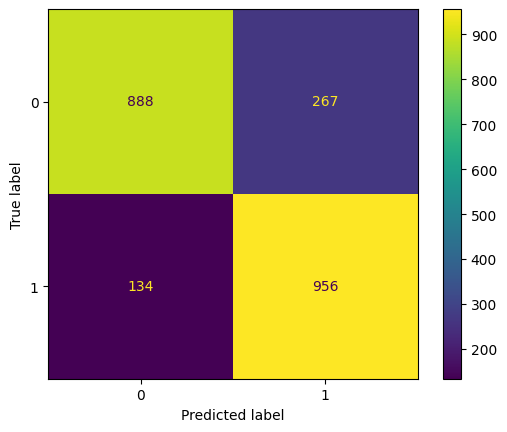

In [12]:
labels_ = m2_pipeline['label'].unique()
print(labels_)
vc.fit(X_train_scaled, y_train)

y_pred_vc = vc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_vc, labels=labels_)

print(classification_report(y_test, y_pred_vc,zero_division=1))

## voting classifier classifier report (error reporting part 2)

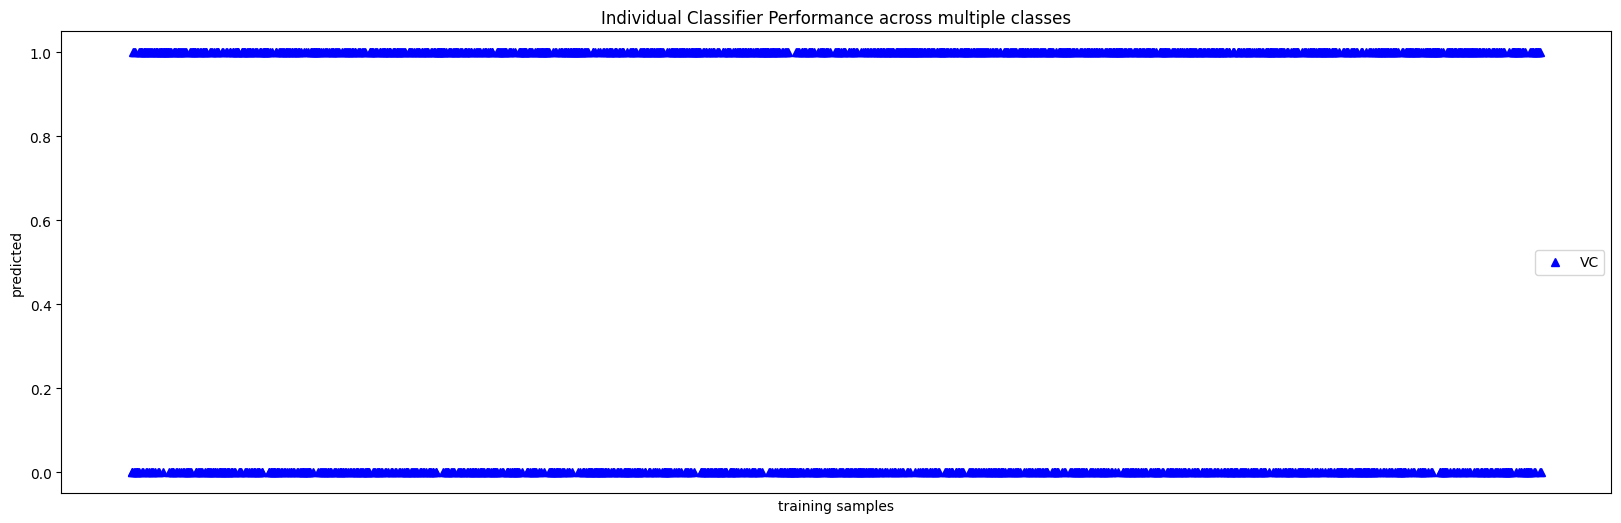

In [13]:
plt.figure(figsize=(20,6))
plt.plot(y_pred_vc, "b^", label="VC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()

### understand the high output classifiers inside the Balanced Random Forest Classifier

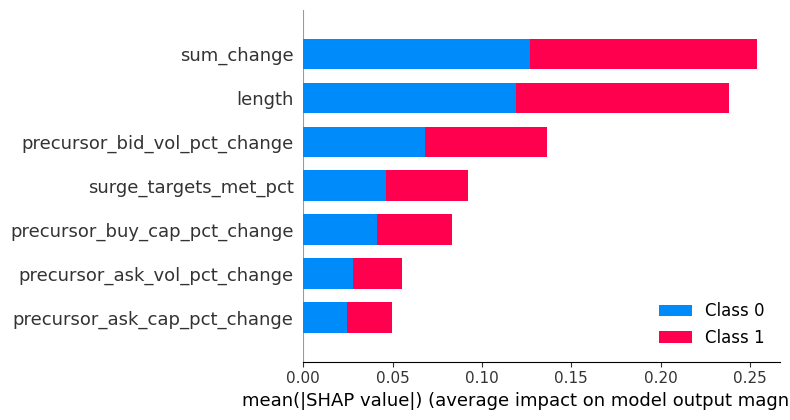

In [14]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = brf.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## binary classifier error reporting

In [15]:
print_dict = lambda x: print(x)

# Apply the lambda function to each row of the data frame
optimals.applymap(print_dict)

LogisticRegression
BernoulliNB
KNeighborsClassifier
{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
{'fit_prior': True}
{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}
0.6806236080178174
0.6489977728285078
0.9314031180400891


,classifier,best_params,accuracy
0,None,None,None
1,None,None,None
2,None,None,None


### logistic regression fit, predict and error reporting

0.6806236080178174
[0 1]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1155
           1       0.68      0.66      0.67      1090

    accuracy                           0.68      2245
   macro avg       0.68      0.68      0.68      2245
weighted avg       0.68      0.68      0.68      2245



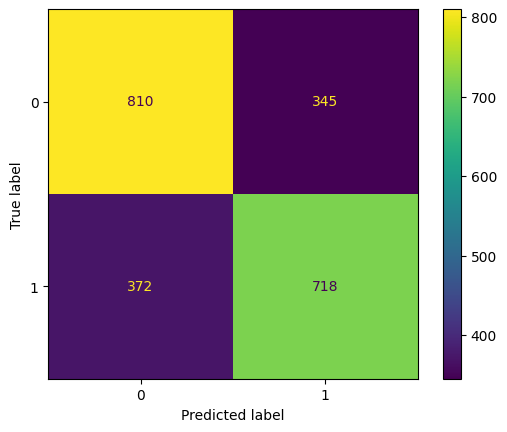

In [16]:
logreg = LogisticRegression(C=10, multi_class='ovr', penalty='l2', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(accuracy_lr)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, labels=labels_)

print(classification_report(y_test, y_pred_lr,zero_division=1))

### Naive Bayes (Bernouilli) classifier accuracy and error report

0.6489977728285078
[0 1]
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1155
           1       0.68      0.52      0.59      1090

    accuracy                           0.65      2245
   macro avg       0.66      0.65      0.64      2245
weighted avg       0.66      0.65      0.64      2245



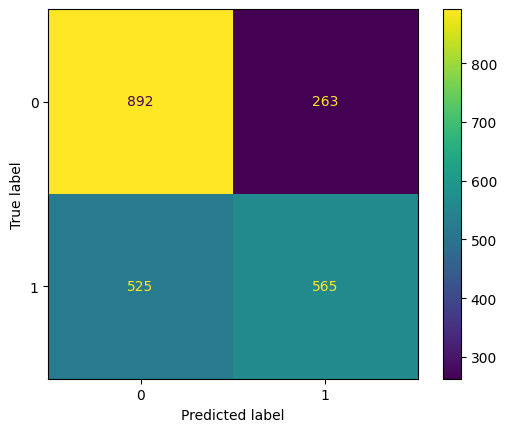

In [17]:
bnb = BernoulliNB(fit_prior=True)
bnb.fit(X_train_scaled, y_train)

y_pred_nb = bnb.predict(X_test_scaled)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(accuracy_nb)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, labels=labels_)

print(classification_report(y_test, y_pred_nb,zero_division=1))

### KN Neighbors Classifier error and classification report

0.9314031180400891
[0 1]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1155
           1       0.90      0.97      0.93      1090

    accuracy                           0.93      2245
   macro avg       0.93      0.93      0.93      2245
weighted avg       0.93      0.93      0.93      2245



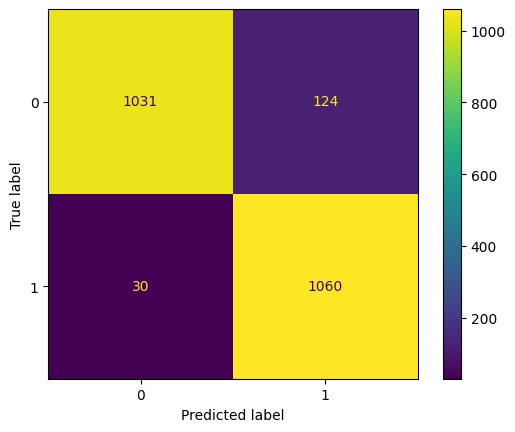

In [18]:
knn = KNeighborsClassifier(algorithm='auto', n_jobs=1, n_neighbors=3)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(accuracy_knn)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, labels=labels_)

print(classification_report(y_test, y_pred_knn ,zero_division=1))

### knn neighbors learning curve

testing different test/train ratios for accuracy

[from sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#plotting-learning-curves-and-checking-models-scalability)

/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/stefanbund/Library/Python/3.9/lib/python/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator`

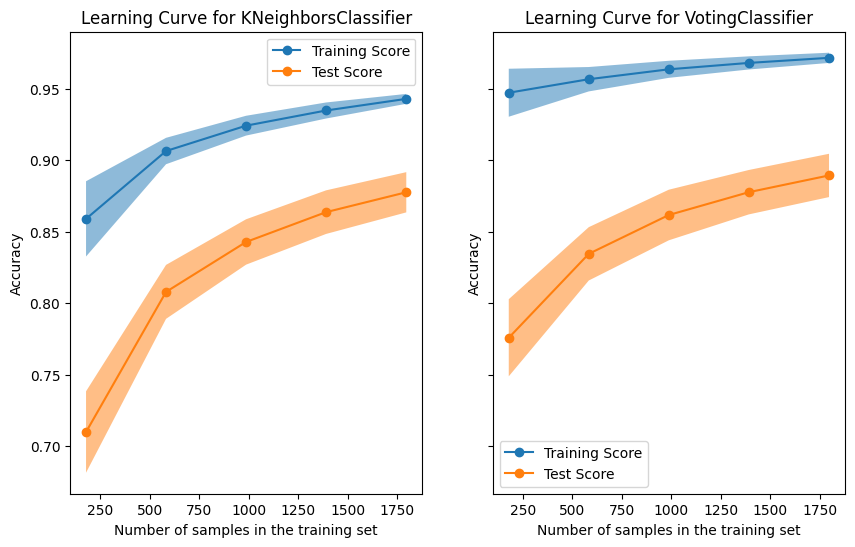

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_test_scaled,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([knn,vc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
